See Kartsaklis et al. _Reasoning about Meaning in Natural Language with Compact Closed Categories and Frobenius Algebras_ ([arXiv:1401.5980](https://arxiv.org/abs/1401.5980))

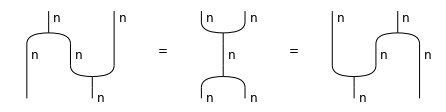

In [1]:
from discopy import Ty, Box, Id, drawing

s, n = Ty('s'), Ty('n')

class Frobenius(Box):
    """
    Implements the boxes for Frobenius algebras.
    """
    def __init__(self, n_legs_in, n_legs_out, _type=n):
        assert len(_type) == 1 # for convenience, we only want spiders for atomic types
        self._type = _type
        dom, cod = _type ** n_legs_in, _type ** n_legs_out
        super().__init__("CUP", dom, cod)  # special name so that Frobenius boxes get drawn as spiders.

    def __repr__(self):
        return "Frobenius({}, {}, {})".format(len(self.dom), len(self.cod), self._type)
    
    def __str__(self):
        return repr(self)

Frobenius_law = (
    Frobenius(1, 2) @ Id(n) >> Id(n) @ Frobenius(2, 1),
    Frobenius(2, 1) >> Frobenius(1, 2),
    Id(n) @ Frobenius(1, 2) >> Frobenius(2, 1) @ Id(n))

drawing.equation(*Frobenius_law)

Three ansätze for the transitive verb 'loves':


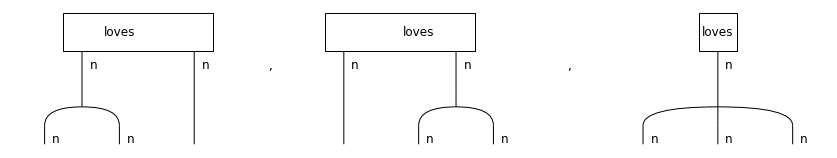

In [2]:
from discopy import Word, Cup

Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)
grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
sentence = Alice @ loves @ Bob >> grammar

love_matrix, love_vector = Box('loves', Ty(), n @ n), Box('loves', Ty(), n)
copy_subj = love_matrix >> Frobenius(1, 2) @ Id(n)
copy_obj = love_matrix >> Id(n) @ Frobenius(1, 2)
multp = love_vector >> Frobenius(1, 3)

print("Three ansätze for the transitive verb 'loves':")
drawing.equation(copy_subj, copy_obj, multp, symbol=',   ', figsize=(12, 2))

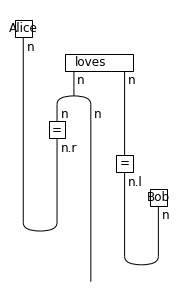

Diagram for 'Alice loves Bob' with the copy_subj ansatz.


In [3]:
from discopy import Functor

class Equal(Box):
    """
    We need isomorphisms from types to their adjoint.
    """
    def __init__(self, x, y):
        super().__init__('=', x, y)

F_copy_subj = Functor(
    ob={n: n, s: n},
    ar={
        Alice: Alice,
        Bob: Bob,
        loves: copy_subj >> Equal(n, n.r) @ Id(n) @ Equal(n, n.l)})
F_copy_subj(sentence).draw()
print("Diagram for 'Alice loves Bob' with the copy_subj ansatz.")

In [4]:
import numpy as np

from discopy import Dim, Tensor, TensorFunctor

class FrobeniusFunctor(TensorFunctor):
    """
    Implements functors into matrices that send abstract Frobenius boxes to their matrix.
    """
    def __call__(self, diagram):
        if isinstance(diagram, Frobenius):
            dim = int(np.prod(self(diagram._type)))
            dom, cod = self(diagram.dom), self(diagram.cod)
            array = np.zeros(dom @ cod)
            for i in range(dim):
                one_hot = np.zeros(dim)
                one_hot[i] = 1
                basis_elem = Tensor(Dim(1), Dim(dim), one_hot)
                state = Tensor.id(Dim(1)).tensor(*(len(dom) * [basis_elem]))
                effect = Tensor.id(Dim(1)).tensor(*(len(cod) * [basis_elem.dagger()]))
                array += (effect >> state).array
            return Tensor(dom, cod, array)
        if isinstance(diagram, Equal):
            return Tensor.id(self(diagram.dom))
        return super().__call__(diagram)

ob, ar = {n: 2, s: 1}, {
    Alice: [0, 1],
    Bob: [1, 0],
    loves: [0, 1, 1, 0],
    love_matrix: [0, 1, 1, 0],
    love_vector: [1, 1]}

F = FrobeniusFunctor(ob, ar)

assert F(Frobenius_law[0]) == F(Frobenius_law[1]) == F(Frobenius_law[2])


F(F_copy_subj(sentence))

Tensor(dom=Dim(1), cod=Dim(2), array=[0.0, 1.0])